# A (gentle) introduction to Linear Regression
## Preface 

This repo has been created for students of DA-203o Introduction to Computing for AI & ML. This notebook is meant as a supplementary hands-on to Prof. Ganesan's lectures on linear regression. You can download the repo as a .zip file from GitHub or clone it,
```
git clone https://github.com/divijghose/DA203o-ICAIML.git
```

You can suggest edits or corrections to this notebook by creating a pull request.

## Contents
1. [Creating dummy data](#creating-dummy-data)
2. [Solving the normal equation](#solving-the-normal-equation)
3. [Gradient Descent](#gradient-descent)
4. [Linear regression with scikit learn](#linear-regression-with-scikit-learn)
5. [Overfitting and Underfitting](#overfitting-and-underfitting)
6. [Regularization](#regularization)
    <br>a.[Ridge Regression](#ridge-regression)
    <br>b.[Lasso Regression](#lasso-regression)
    <br>c.[Elastic Net](#elastic-net)


In [197]:
# Import the requisite libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

%matplotlib inline

## Creating dummy data
The following function creates a dummy dataset with and underlying linear model and some added noise. For a given input of number of features and number of samples, the function uses `make_regression` to return a set of features, target and coefficients for the best fit. These coefficient can then be used as a benchmark for any model that you build.
<br>[back to contents](#contents)

In [198]:
def makeDummyData(n_features, n_samples):
    x, y, coeff = datasets.make_regression(n_samples=n_samples,#number of samples
                                      n_features=n_features,#number of features
                                      n_informative=n_features,#number of useful features 
                                      noise=2,#bias and standard deviation of the guassian noise
                                      coef=True,#true coefficient used to generated the data
                                      random_state=42) #set for same data 
    return x,y,coeff

## Solving the normal equation
The normal equation for the least squares problem is given by $$ \hat{\beta}= (X^TX)^{-1}X^Ty$$ For smaller datasets, it is feasible to obtain a closed form solution of this equation and thus find the value of coefficients for the best fit. The code below defines a function which finds the solution of the normal equation for a given dataset.
<br>[back to contents](#contents)


In [199]:
def fitNormalEquation(X, y):
        """
        Fit model coefficients.

        Arguments:
        X: 1D or 2D numpy array 
        |x11 x12  .... x1n | 
        |x21 x22  .... x2n |
        | .   .     .   .  |
        | .   .     .   .  |
        |xm1 xm2  .... xmn |

        y: 1D numpy array
        | y1 |
        | y2 |
        | .  |
        | .  |
        | ym |
        """
        
        
        if len(X.shape) == 1: # check if X is 1D or 2D array
            X = X.reshape(-1,1) #reshape to column vector if 1D 
            
        # add bias terms to feature matrix
        X_biased = np.c_[np.ones(X.shape[0]), X] #Adds a leading column of 1's to feature matrix to fit the intercept
        #| 1 x11 x12  .... x1n | 
        #| 1 x21 x22  .... x2n |
        #| .  .   .     .   .  |
        #| .  .   .     .   .  |
        #| 1 xm1 xm2  .... xmn |
        
        
        # closed form solution
        xTx = np.dot(X_biased.T, X_biased)
        inverse_xTx = np.linalg.inv(xTx)
        xTy = np.dot(X_biased.T, y)
        sol = np.dot(inverse_xTx, xTy)
        
        intercept = sol[0]
        coeff = sol[1:]
        print(f"Fit intercept: {intercept}\n")
        print(f"Fit coefficients: {coeff}\n")
        return coeff

In [200]:
# Make dummy dataset to test normal equation 
X_normeq,y_normeq,coeff_actual = makeDummyData(4,100)

# Find coefficients using normal equation
coeff_norm = fitNormalEquation(X_normeq,y_normeq)

#Compare with actual coefficients
print(f"Actual coefficients: {coeff_actual}\n")

Fit intercept: -0.015668834683909116

Fit coefficients: [86.56527327  5.65748265 27.2283207  41.12314002]

Actual coefficients: [86.47223763  5.63754967 27.34070719 41.48195023]



## Gradient Descent
Gradient descent is an iterative algorithm which is particularly useful in solving the least squares problem when the data size is large - lots of features and lots of samples. Gradient descent measures the local gradient of the error function with respect to the coefficient vector $\hat{\beta}$ and then goes in the direction of the descending gradient. Once the gradient is zero, a minima is reached. The following code implements gradient descent from scratch.
<br>[back to contents](#contents)


In [215]:
# gradient descent 
X_gd,y_gd, coeff_actual = makeDummyData(1,1000)
# y_gd=y_gd.reshape(-1,1)


In [216]:
def gradient_descent(b0, b1, stepsize): 
    # calculate gradient descent 
    g_b0 = -2*np.sum(y_gd-(b0+b1*X_gd))
    g_b1 = -2*np.sum([(y_i-(b0+b1*x_i))*x_i for x_i, y_i in zip(X_gd, y_gd)])
    # update both b0 and b1
    b1_new = b1 - stepsize*g_b1
    b0_new = b0 - stepsize*g_b0
    return b0_new, b1_new, g_b0, g_b1

In [217]:
stepsize = 0.01
b0=0
b1=0
g_b0 = 1 
g_b1 = 1
while (np.sqrt(g_b0**2 + g_b1**2) > 0.0001):
    # get b0 and b1 at t+1
    b0, b1, g_b0, g_b1 = gradient_descent(b0, b1, stepsize)

/tmp/ipykernel_931721/2507646883.py:6: RuntimeWarning: overflow encountered in double_scalars
  while (np.sqrt(g_b0**2 + g_b1**2) > 0.0001):
/home/divij/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_931721/1807776388.py:7: RuntimeWarning: invalid value encountered in double_scalars
  b0_new = b0 - stepsize*g_b0


In [223]:
g_b0 = -2.0*np.sum(y_gd-(b0+b1*X_gd))

In [222]:
g_b0

nan

## Linear Regression with scikit learn
We will now turn our attention to the implementation of linear regression models using the `scikit learn` package. We'l use the _California Housing Price_ sample data, a popular starting point for beginners. We will first load the dataset and then split it into two parts: the training set (80%) and the test set(20%). A linear model will be fit on the training set and its performance will be evaluated on the test set. 
<br>[back to contents](#contents)

In [ ]:
# Load the dataset
house = datasets.fetch_california_housing()

# Print info about the dataset
print("The data shape of house is {}".format(house.data.shape))
print("The number of feature in this data set is {}".format(
    house.data.shape[1]))

# Convert to a dataframe
description = house["DESCR"]
feature_names = house["feature_names"]
data = house["data"]
target = house["target"]
house_df1 = pd.DataFrame(data=data)
house_df1.rename(columns={0: feature_names[0], 1: feature_names[1], 2: feature_names[2], 3: feature_names[3],
 4: feature_names[4], 5: feature_names[5], 6: feature_names[6], 7: feature_names[7]}, inplace=True)
house_df2 = pd.DataFrame(data=target)
house_df2.rename(columns={0: "Target"}, inplace=True)
housing_df = pd.concat([house_df1, house_df2], axis=1)

The data shape of house is (20640, 8)
The number of feature in this data set is 8


In [ ]:
# Explore the data
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(housing_df.loc[:, housing_df.columns != "Target"], housing_df["Target"], random_state=66)

In [ ]:
# Create a Linear Regression object
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

# Predict target values for test set using fit coefficients
y_pred = lr.predict(X_test)

# Print error metrics
## Mean squared error
mse = mean_squared_error(y_test,y_pred)
print("Mean Squared Error: {}".format(mse))
## Mean absolute error
mae = mean_absolute_error(y_test,y_pred)
print("Mean Absolute Error: {}".format(mae))
## R2 score for training and testing
r2_train = lr.score(X_train,y_train)
r2_test = lr.score(X_test,y_test)
print("R² Score of linear regressor on training set: {}".format(r2_train))
print("R² Score of linear regressor on test set: {}".format(r2_test))

Mean Squared Error: 0.5355012511132707
Mean Absolute Error: 0.5344537291379876
R² Score of linear regressor on training set: 0.6032624255930834
R² Score of linear regressor on test set: 0.6091409258885421


## Overfitting and Underfitting
The underlying complexity of your chosen model decides whether the model will underfit or overfit the data. One way to increase the complexity of a model is to increase the degree of the polynomial to be fit on the data. In the following blocks of code, we fit a polynomial of degrees 1, 4 and 20 on a dataset generated by adding noise to a known function, and observe how closely the fit polynomial approximates the known function.
[back to contents](#contents)


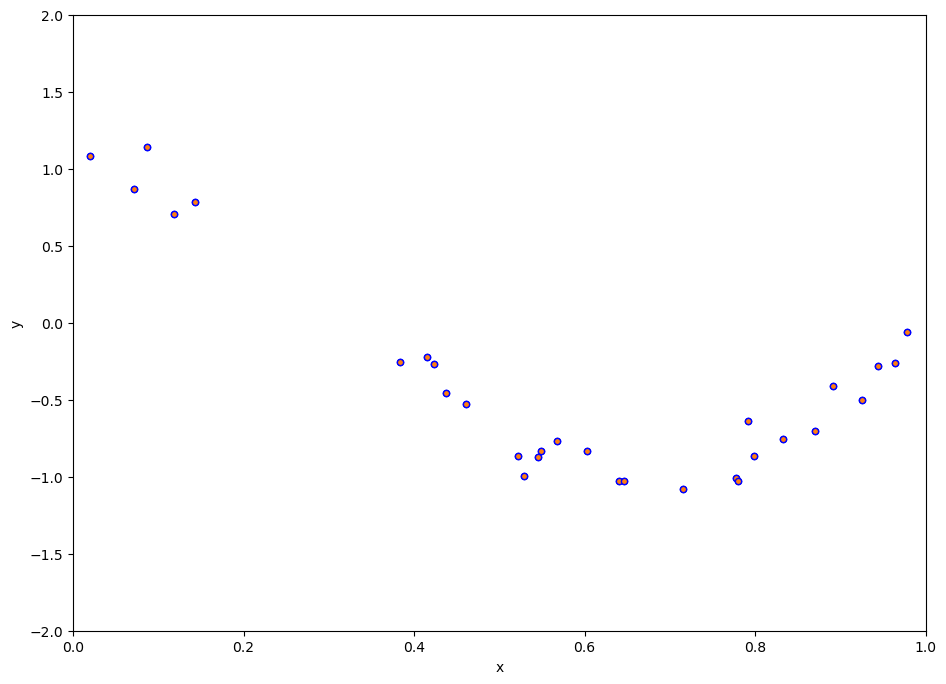

In [ ]:
# Define the known function
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# Generate training and test data by adding noise to the known function
np.random.seed(0)
n_samples = 30
degrees = [1, 4, 20]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

# visualize data
plt.figure(figsize=(11,8 ))
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

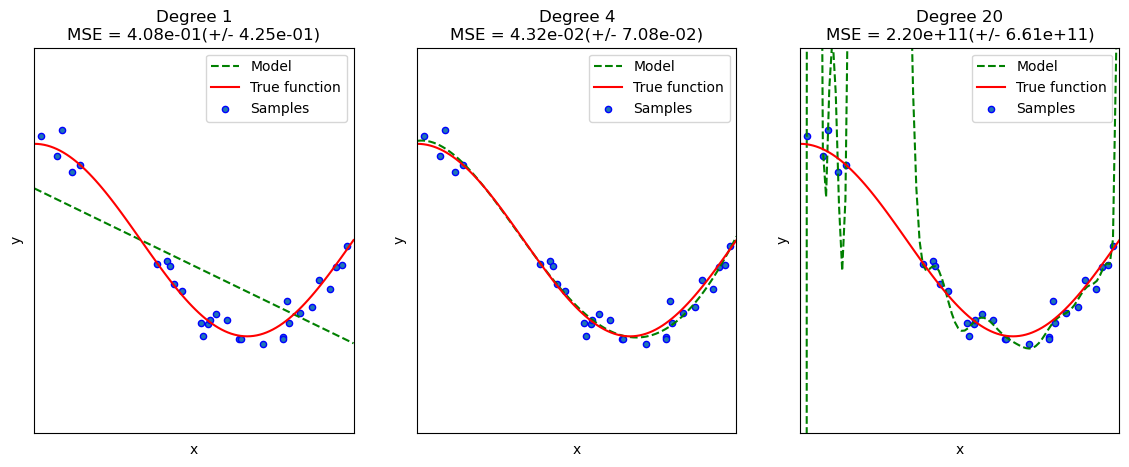

In [ ]:
# Fit each polynomial model and visualize the fit 
plt.figure(figsize=(14,5 ))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = linear_model.LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features), # apply a polynomial transformation to all features
            ("linear_regression", linear_regression),     # linear estimator
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]),'g--', label="Model")
    plt.plot(X_test, true_fun(X_test),'r', label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Regularization

[back to contents](#contents)


### Ridge Regression
[back to contents](#contents)


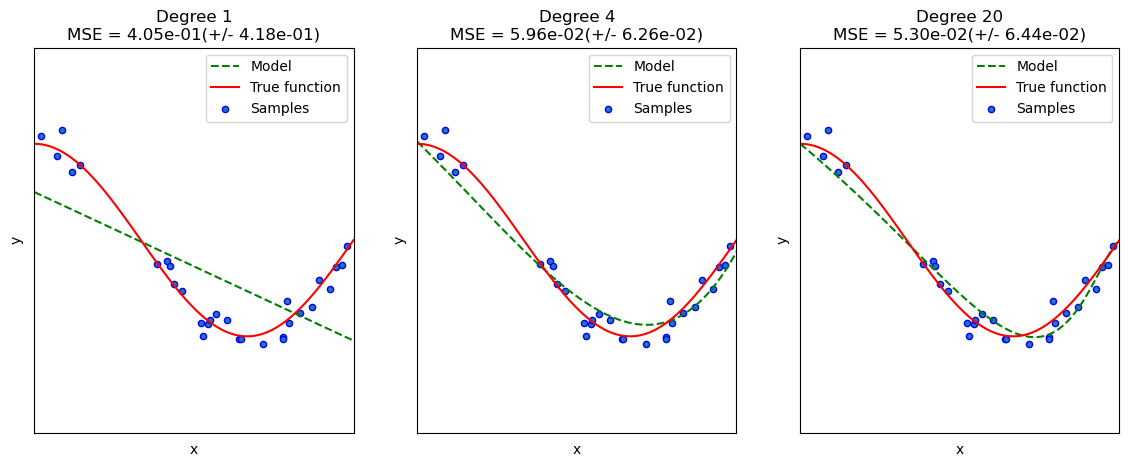

In [ ]:
# Fit each polynomial model and visualize the fit 
plt.figure(figsize=(14,5 ))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = linear_model.Ridge(alpha=0.1)
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features), # apply a polynomial transformation to all features
            ("linear_regression", linear_regression),     # linear estimator
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]),'g--', label="Model")
    plt.plot(X_test, true_fun(X_test),'r', label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

### Lasso Regression
[back to contents](#contents)


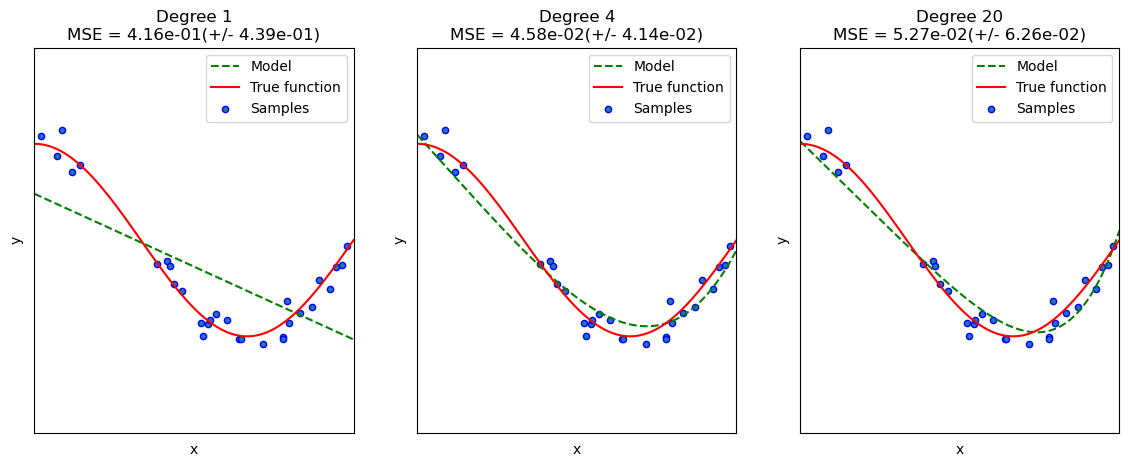

In [ ]:
# Fit each polynomial model and visualize the fit 
plt.figure(figsize=(14,5 ))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = linear_model.Lasso(alpha=0.0075)
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features), # apply a polynomial transformation to all features
            ("linear_regression", linear_regression),     # linear estimator
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]),'g--', label="Model")
    plt.plot(X_test, true_fun(X_test),'r', label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

### Elastic Net
[back to contents](#contents)


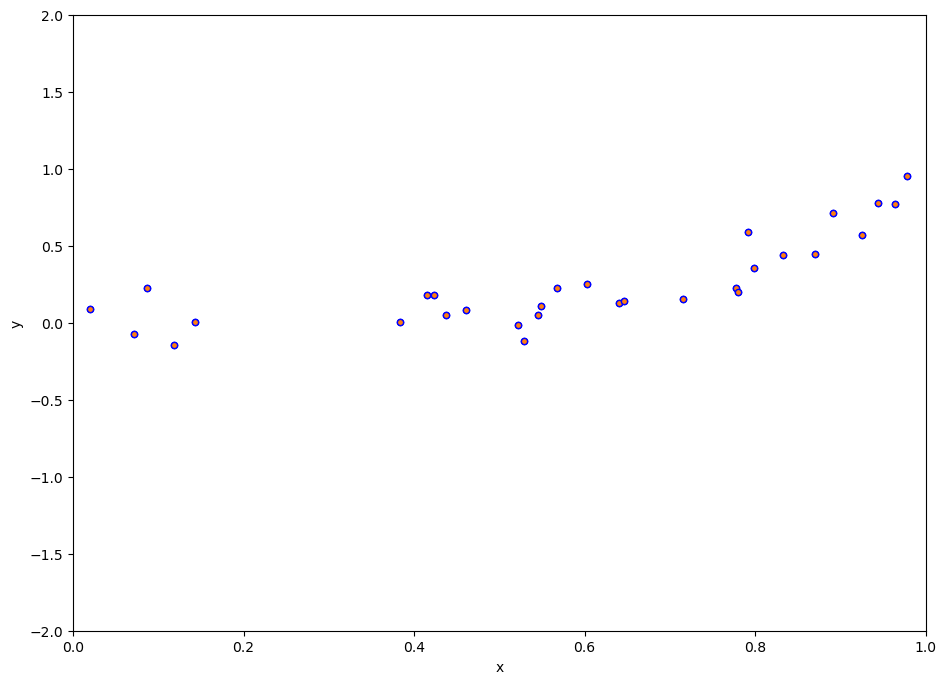

In [ ]:
# Define the known function
def true_fun(X):
    return np.power(X,4)
    

# Generate training and test data by adding noise to the known function
np.random.seed(0)
n_samples = 30
degrees = [1, 4, 20]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

# visualize data
plt.figure(figsize=(11,8 ))
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

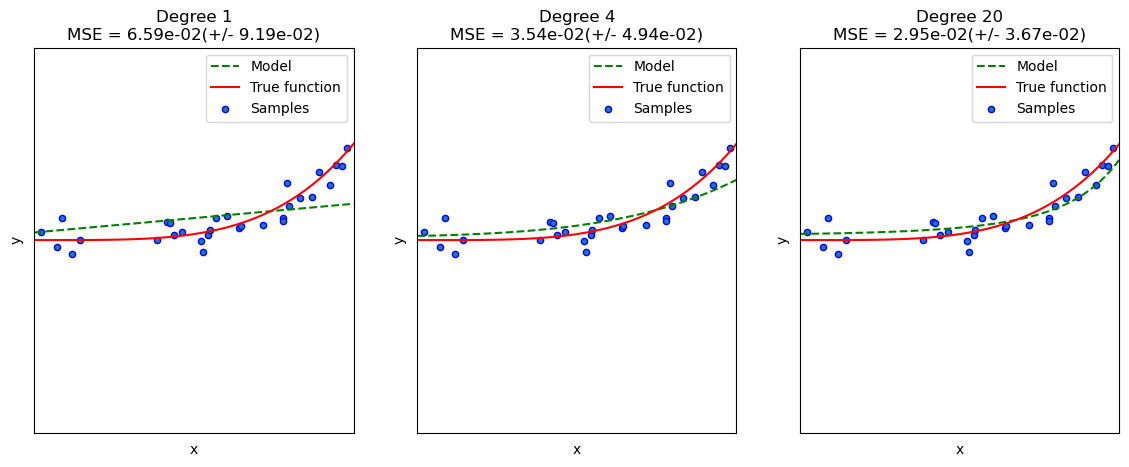

In [ ]:
# Fit each polynomial model and visualize the fit 
plt.figure(figsize=(14,5 ))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = linear_model.ElasticNet(alpha=0.1,l1_ratio=0.1)
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features), # apply a polynomial transformation to all features
            ("linear_regression", linear_regression),     # linear estimator
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]),'g--', label="Model")
    plt.plot(X_test, true_fun(X_test),'r', label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()